# Regression - Prediciting Life Expectancy for US

### [TBD] Now it is time to use other models to reduce the complexity of our baseline model by using several feature selection techniques. The aim here is to reduce the amount of features for our 'client', there will no doubt be some tradeoff between model accuracy and complexity.

As we can see above, we get a R2 scores of 83% for a single train-test split model and 88% if we conduct a cross-validation with 5 splits. This however might result in a model that is too complex noting the number of features we have. Let's conduct two different ways of selecting only the best features:
- filter methods
    - low variance
    - Pearson's Correlation (Given majority of our features are continuous)
- wrapper methods
    - Recurvsive Feature Elimination
    - Stepwise Selection
- embedded methods 
    - Lasso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from functions import *

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.preprocessing import StandardScaler

from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
df_clean = pd.read_csv('clean_data.csv', index_col = [0])

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy']
X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy']

Split into training and testing dataset, followed by a subsequent split within the training bucket into training and validation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [5]:
scx = StandardScaler()
scy = StandardScaler()

X_train_scaled = pd.DataFrame(scx.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scx.transform(X_test), columns = X_test.columns)
y_train_scaled = np.concatenate(scy.fit_transform(np.array(y_train).reshape(-1,1)))
y_test_scaled = np.concatenate(scy.transform(np.array(y_test).reshape(-1,1)))

# to_scale = df_clean.drop(['State_Abbreviation', 'Name'], axis = 1)
# Scaled_data = sc.fit_transform(to_scale)
# Scaled_data_df = pd.DataFrame(Scaled_data, columns = [to_scale.columns])

# X_scaled = Scaled_data_df.drop('Life_expectancy', axis = 1)
# y_scaled = Scaled_data_df['Life_expectancy'].values

In [6]:
print ('Total training data:', len(X_train_subset))
print ('Total validation data:', len(X_val))
print ('Total test date:', len(X_test))
print ('Total data:', len(X))
print ('Cross check:',  len(X) == len(X_train_subset) + len(X_val) + len(X_test))

Total training data: 1767
Total validation data: 589
Total test date: 786
Total data: 3142
Cross check: True


Create a dataframe to store all model outcomes which will be useful to derive a conclusion at a later stage

In [7]:
all_model_summary_df = pd.DataFrame([], columns = ['model', 'R2_test', 'AIC', 'n_features', '>0.05_pvalues'])
all_model_summary_df['model'] = ['Baseline', 'Basic - Top Correlation',
                                 'Filter', 
                                 'Wrappper - RFE', 'Wrappper - Stepwise',
                                 'Embedded - Lasso']

### 1. Baseline model - All available features

This is a very basic model which accounts for all 76 features purely using the X_train dataset (no validation)

In [8]:
baseline_OLS = OLS(y_train_scaled, add_constant(X_train_scaled)).fit()

baseline_predictions = baseline_OLS.predict(add_constant(X_test_scaled))
baseline_train_r2 = baseline_OLS.rsquared

baseline_test_r2 = r2_score(y_test_scaled, baseline_predictions)

In [9]:
baseline_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     377.5
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:11   Log-Likelihood:                -496.19
No. Observations:                2356   AIC:                             1118.
Df Residuals:                    2293   BIC:                             1482.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 7.112e-16      0.006   1.14e-13      1.000      -0.012       0.012
Release_Year                                                          -3.47e-15   3.42e-16    -10.155      0.000   -4.14e-15    -2.8e-15
County_Ranked_(Yes=1/No=0)                                               0.0071      0.008      0.874      0.382      -0.009       0.023
Premature_death                                                         -0.0334      0.026     -1.292      0.196      -0.084       0.017
Poor_or_fair_health                                                      0.0588      0.029      2.016      0.044       0.002       0.116
Poor_physical_health_days                                               -0.1248      0.064     -1.951      0.051      -0.250       0.001
Poor_mental_health_days                                                 -0.0630      0.041     -1.530      0.126      -0.144       0.018
Low_birthweight                                                         -0.0161      0.011     -1.518      0.129      -0.037       0.005
Adult_smoking                                                           -0.0413      0.017     -2.453      0.014      -0.074      -0.008
Adult_obesity                                                           -0.0154      0.011     -1.423      0.155      -0.037       0.006
Food_environment_index                                                  -0.0841      0.123     -0.681      0.496      -0.326       0.158
Physical_inactivity                                                     -0.0067      0.012     -0.532      0.595      -0.031       0.018
Access_to_exercise_opportunities                                        -0.0281      0.009     -3.016      0.003      -0.046      -0.010
Excessive_drinking                                                       0.0160      0.012      1.372      0.170      -0.007       0.039
Alcohol-impaired_driving_deaths                                         -0.0037      0.007     -0.565      0.572      -0.016       0.009
Sexually_transmitted_infections                                         -0.0008      0.010     -0.082      0.935      -0.021       0.019
Teen_births                                                              0.0086      0.014      0.636      0.525      -0.018       0.035
Uninsured                                                                1.7782      0.151     11.804      0.000       1.483       2.074
Primary_care_physicians                                                 -0.0359      0.009     -3.887      0.000      -0.054      -0.018
Dentists                                                             

In [10]:
linreg = LinearRegression()
score = np.mean(cross_val_score(linreg, X_train, y_train, cv = 5))
score

0.896398319152579

Now, let's check the R2 of the train and test sets as well as plot the residuals

Baseline Train R-Squared: 0.91
Baseline Test R-Squared: 0.84


Check for Homoscedasticity Assumption


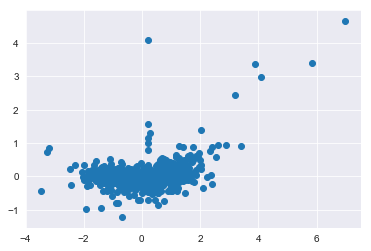

Check for Residuals Normality


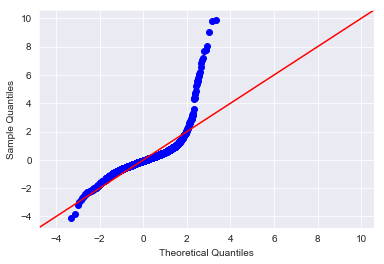

In [11]:
baseline_errors = y_test_scaled - baseline_predictions

print ('Baseline Train R-Squared:', round(baseline_train_r2, 2))
print ('Baseline Test R-Squared:', round(baseline_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test_scaled, y = baseline_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(baseline_OLS.resid, dist=stats.norm, line='45', fit=True)

Rule of thumb threshold is VIF at the level of 2.5, meaning if the VIF is above 2.5 you should consider there is effect of multicollinearity on your fitted model

In [12]:
# X_baseline = X_train_scaled
# X_baseline['Intercept'] = 1

# Baseline_VIF = pd.DataFrame()
# Baseline_VIF["variables"] = X_baseline.columns
# Baseline_VIF["VIF"] = [variance_inflation_factor(X_baseline.values, i) for i in range(X_baseline.shape[1])]

# Baseline_VIF

In [13]:
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'n_features'] = len(baseline_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'AIC'] = baseline_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'R2_test'] = baseline_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', '>0.05_pvalues'] = sum(baseline_OLS.pvalues > 0.05)

In [14]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 2. Basic - Features with Highest Correlation with Target

Given we've blindly included all features in the baseline model, let's try and narrow these down to only include features which are highly correlated with 'Life Expectancy'. First, we initiated a correlation matrix and set our target correlation threshold to 0.65.

In [15]:
initial_matrix = abs(df_clean.corr().Life_expectancy)

target_correlation_threshold = 0.65

final = list(initial_matrix[(initial_matrix.sort_values(ascending=False) > target_correlation_threshold)].index)
final.remove('Life_expectancy')
final

['Premature_death',
 'Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

Using a 0.65 threshold, we've narrowed down our features from 76 to 6 features. Using these 6 features, let's create another OLS model and evaluate its performance.

In [16]:
basic_correlation_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test_scaled[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test_scaled, basic_predictions)

In [17]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3007.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:12   Log-Likelihood:                -797.17
No. Observations:                2356   AIC:                             1608.
Df Residuals:                    2349   BIC:                             1649.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             1.082e-15      0.007   1.54e-13      1.000      -0.014       0.014
Premature_death                      0.0193      0.023      0.826      0.409      -0.026       0.065
Poor_physical_health_days           -0.2860      0.040     -7.224      0.000      -0.364      -0.208
Adult_smoking                       -0.0808      0.013     -6.117      0.000      -0.107      -0.055
Premature_age-adjusted_mortality    -0.9280      0.025    -37.377      0.000      -0.977      -0.879
Frequent_physical_distress           0.4619      0.040     11.498      0.000       0.383       0.541
Frequent_mental_distress            -0.1398      0.026     -5.438      0.000      -0.190      -0.089
==============================================================================
Omnibus:                     2330.297   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171800.511
Skew:                           4.630   Prob(JB):                         0.00
Kurtosis:                      43.796   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks like the 'Premature_death' feature is not significant according its p-value. Let's re-run the model again excluding this feature.

In [18]:
final.remove('Premature_death')
final

['Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

In [19]:
basic_correlation_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test_scaled[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test_scaled, basic_predictions)

In [20]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3609.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:12   Log-Likelihood:                -797.51
No. Observations:                2356   AIC:                             1607.
Df Residuals:                    2350   BIC:                             1642.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             1.082e-15      0.007   1.54e-13      1.000      -0.014       0.014
Poor_physical_health_days           -0.2915      0.039     -7.469      0.000      -0.368      -0.215
Adult_smoking                       -0.0813      0.013     -6.155      0.000      -0.107      -0.055
Premature_age-adjusted_mortality    -0.9095      0.011    -84.558      0.000      -0.931      -0.888
Frequent_physical_distress           0.4644      0.040     11.596      0.000       0.386       0.543
Frequent_mental_distress            -0.1367      0.025     -5.375      0.000      -0.187      -0.087
==============================================================================
Omnibus:                     2347.908   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           176856.921
Skew:                           4.682   Prob(JB):                         0.00
Kurtosis:                      44.399   Cond. No.                         15.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Good, dropping the feature does not impact our R2. Let's now conduct further analysis on the R-Squares, Residuals' Homoscedasticity and Normality

Basic Train R-Squared: 0.88
Basic Test R-Squared: 0.82


Check for Homoscedasticity Assumption


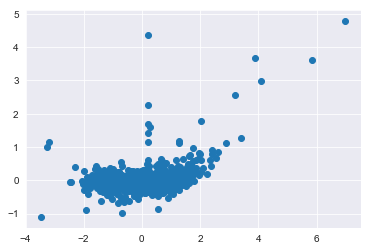

Check for Residuals Normality


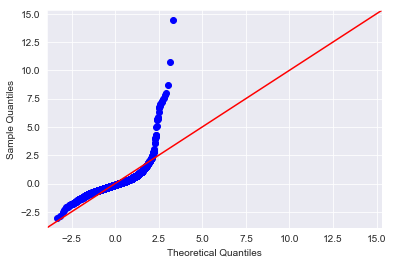

In [21]:
basic_errors = y_test_scaled - basic_predictions

print ('Basic Train R-Squared:', round(basic_train_r2, 2))
print ('Basic Test R-Squared:', round(basic_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test_scaled, y = basic_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(basic_correlation_OLS.resid, dist = stats.norm, line='45', fit=True)

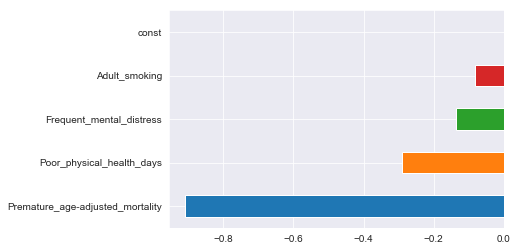

In [22]:
coef_basic = basic_correlation_OLS.params.sort_values()
coef_basic[:5].plot(kind = 'barh', figsize = (6,4))
plt.show()

In [23]:
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'n_features'] = len(basic_correlation_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'AIC'] = basic_correlation_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'R2_test'] = basic_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', '>0.05_pvalues'] = sum(basic_correlation_OLS.pvalues > 0.05)

In [24]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,0.817139,1607.02,6,1
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


Just by using the 6 top correlated features, we get almost similar results to our Baseline model and is much more user friendly for our client!

### 3. Filter Method - drop features with no or low variance & high correlation with other features

One of the pitfalls of the above method is that we might have potentially ignored other useful features that might be of use to our client. Also, the baseline model might include various highly correlated features which violates the assumptions of a regression model. As such, let's try out best to find a middle ground by using the filter methods, first by:

- dropping features with no or low variance. These features typically do not add much predictive value
- dropping features which are highly correlated

Let's start of by dropping features with no or low variance. We can use Sklearn's variance threshold tool to remove features with low threshold (we set it at 0.025).

In [25]:
variance_threshold = 0.00

low_var_filter = VarianceThreshold(threshold = variance_threshold)
low_var_filter.fit(X_train)

VarianceThreshold(threshold=0.0)

In [26]:
dropped_cols = X_train.columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(dropped_cols))

Number of low variance features: 1


In [27]:
High_Var_Features = X_train.drop(dropped_cols, axis = 1)

Now we have removed them, let's further narrow down features by excluding highly correlated features. We have defined highly correlated features as those with pearson's r of 0.7 or more

In [28]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.6

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

{'Adult_smoking',
 'Children_eligible_for_free_or_reduced_price_lunch',
 'Children_in_poverty',
 'Children_in_single-parent_households',
 'Diabetes_prevalence',
 'Excessive_drinking',
 'Food_insecurity',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Injury_deaths',
 'Insufficient_sleep',
 'Limited_access_to_healthy_foods',
 'Median_household_income',
 'Percentage_of_households_with_high_housing_costs',
 'Percentage_of_households_with_overcrowding',
 'Physical_inactivity',
 'Poor_mental_health_days',
 'Poor_or_fair_health',
 'Poor_physical_health_days',
 'Premature_age-adjusted_mortality',
 'Severe_housing_cost_burden',
 'Some_college',
 'Teen_births',
 'Uninsured_adults',
 'Uninsured_children'}

In [29]:
High_Var_Features_Low_Corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [30]:
filter_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[High_Var_Features_Low_Corr.columns])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test_scaled[High_Var_Features_Low_Corr.columns]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test_scaled, filter_predictions)

In [31]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     358.3
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:13   Log-Likelihood:                -1099.1
No. Observations:                2356   AIC:                             2274.
Df Residuals:                    2318   BIC:                             2493.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 1.364e-15      0.008    1.7e-13      1.000      -0.016       0.016
County_Ranked_(Yes=1/No=0)                                               0.0194      0.010      1.959      0.050   -2.04e-05       0.039
Premature_death                                                         -0.7451      0.015    -50.603      0.000      -0.774      -0.716
Low_birthweight                                                         -0.0325      0.012     -2.722      0.007      -0.056      -0.009
Adult_obesity                                                           -0.0777      0.011     -7.036      0.000      -0.099      -0.056
Food_environment_index                                                  -0.0384      0.013     -3.064      0.002      -0.063      -0.014
Access_to_exercise_opportunities                                         0.0185      0.012      1.584      0.113      -0.004       0.041
Alcohol-impaired_driving_deaths                                          0.0110      0.008      1.326      0.185      -0.005       0.027
Sexually_transmitted_infections                                          0.0176      0.012      1.463      0.144      -0.006       0.041
Uninsured                                                               -0.0198      0.012     -1.686      0.092      -0.043       0.003
Primary_care_physicians                                                 -0.0063      0.012     -0.548      0.584      -0.029       0.016
Dentists                                                                 0.0069      0.011      0.636      0.525      -0.014       0.028
Mental_health_providers                                                 -0.0227      0.011     -2.144      0.032      -0.044      -0.002
Preventable_hospital_stays                                              -0.0534      0.010     -5.491      0.000      -0.073      -0.034
Mammography_screening                                                    0.0265      0.011      2.331      0.020       0.004       0.049
Flu_vaccinations                                                        -0.0048      0.011     -0.426      0.670      -0.027       0.017
High_school_graduation                                                   0.0025      0.009      0.262      0.793      -0.016       0.021
Unemployment                                                            -0.0085      0.011     -0.764      0.445      -0.030       0.013
Income_inequality                                                        0.0287      0.011      2.724      0.007       0.008       0.049
Social_associations                                                  

Looks like there are more features with high p-values. Once again, let's remove them and refit the model

In [32]:
updated_filter_features = filter_OLS.pvalues
updated_filter_features = updated_filter_features[updated_filter_features < 0.05]
# updated_filter_features.drop('const', axis = 0, inplace = True)
updated_filter_features.index

Index(['Premature_death', 'Low_birthweight', 'Adult_obesity',
       'Food_environment_index', 'Mental_health_providers',
       'Preventable_hospital_stays', 'Mammography_screening',
       'Income_inequality', 'Violent_crime',
       'Air_pollution_-_particulate_matter', 'Severe_housing_problems',
       'Driving_alone_to_work', 'Motor_vehicle_crash_deaths',
       'Firearm_fatalities', 'Homeownership', 'Population',
       '%_not_proficient_in_English', '%_Females', '%_Rural'],
      dtype='object')

In [33]:
filter_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[updated_filter_features.index])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test_scaled[updated_filter_features.index]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test_scaled, filter_predictions)

In [34]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     694.8
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:13   Log-Likelihood:                -1110.9
No. Observations:                2356   AIC:                             2262.
Df Residuals:                    2336   BIC:                             2377.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               1.082e-15      0.008   1.35e-13      1.000      -0.016       0.016
Premature_death                       -0.7501      0.013    -57.495      0.000      -0.776      -0.725
Low_birthweight                       -0.0217      0.011     -2.033      0.042      -0.043      -0.001
Adult_obesity                         -0.0747      0.011     -7.080      0.000      -0.095      -0.054
Food_environment_index                -0.0289      0.011     -2.630      0.009      -0.050      -0.007
Mental_health_providers               -0.0200      0.010     -2.086      0.037      -0.039      -0.001
Preventable_hospital_stays            -0.0560      0.010     -5.862      0.000      -0.075      -0.037
Mammography_screening                  0.0322      0.010      3.209      0.001       0.013       0.052
Income_inequality                      0.0293      0.010      2.861      0.004       0.009       0.049
Violent_crime                         -0.0281      0.010     -2.836      0.005      -0.048      -0.009
Air_pollution_-_particulate_matter    -0.1019      0.010    -10.093      0.000      -0.122      -0.082
Severe_housing_problems               -0.0253      0.012     -2.200      0.028      -0.048      -0.003
Driving_alone_to_work                 -0.1081      0.011     -9.635      0.000      -0.130      -0.086
Motor_vehicle_crash_deaths            -0.0510      0.011     -4.460      0.000      -0.073      -0.029
Firearm_fatalities                    -0.0268      0.010     -2.723      0.007      -0.046      -0.007
Homeownership                          0.0344      0.012      2.927      0.003       0.011       0.057
Population                             0.0343      0.009      3.695      0.000       0.016       0.052
%_not_proficient_in_English            0.0706      0.010      7.046      0.000       0.051       0.090
%_Females                              0.0233      0.009      2.669      0.008       0.006       0.040
%_Rural                                0.0202      0.013      1.598      0.110      -0.005       0.045
==============================================================================
Omnibus:                     2051.640   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147202.382
Skew:                           3.729   Prob(JB):                         0.00
Kurtosis:                      40.999   Cond. No.                         3.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Filter Train R-Squared: 0.85
Filter Test R-Squared: 0.77


Check for Homoscedasticity Assumption


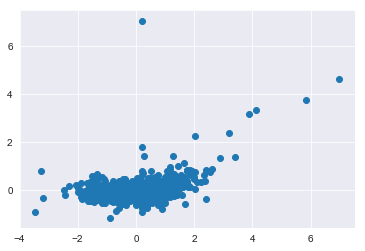

Check for Residuals Normality


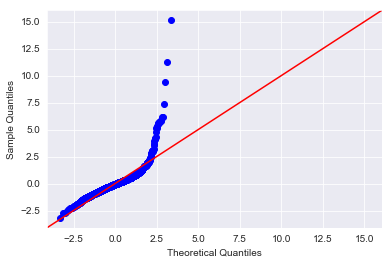

In [35]:
filter_errors = y_test_scaled - filter_predictions

print ('Filter Train R-Squared:', round(filter_train_r2, 2))
print ('Filter Test R-Squared:', round(filter_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test_scaled, y = filter_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(filter_OLS.resid, dist=stats.norm, line='45', fit=True)

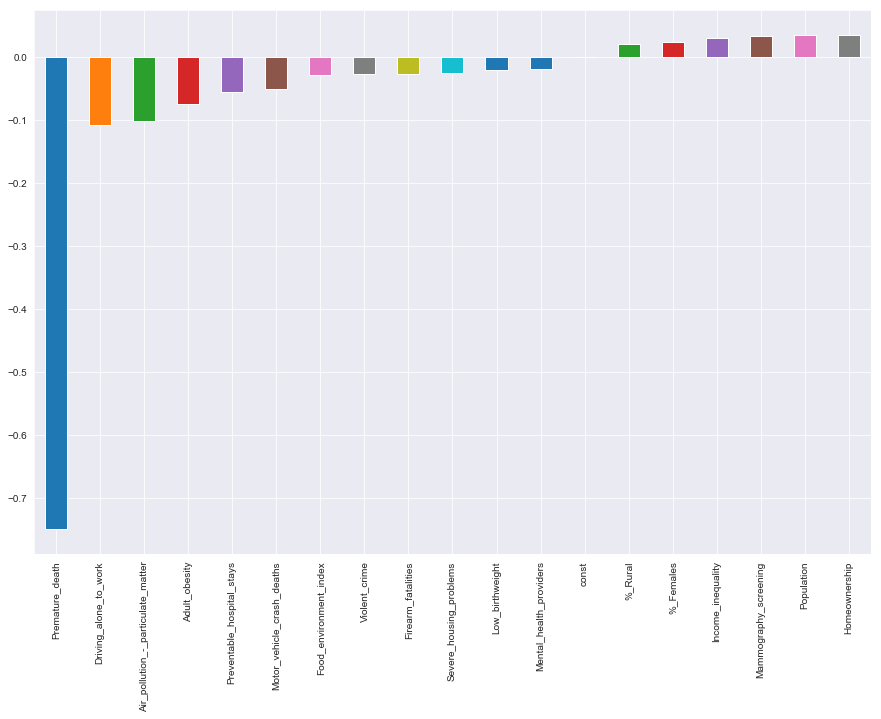

In [36]:
coef_filter = filter_OLS.params.sort_values()
coef_filter[:-1].plot(kind = 'bar', figsize = (15,10))
plt.show()

In [37]:
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'n_features'] = len(filter_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'AIC'] = filter_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'R2_test'] = filter_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', '>0.05_pvalues'] = sum(filter_OLS.pvalues > 0.05)

In [38]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,0.817139,1607.02,6,1
2,Filter,0.767399,2261.76,20,2
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 4. Wrapper - Recursive Feature Elimination

In [39]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=10)
rfecv.fit(X_train_scaled, y_train_scaled)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

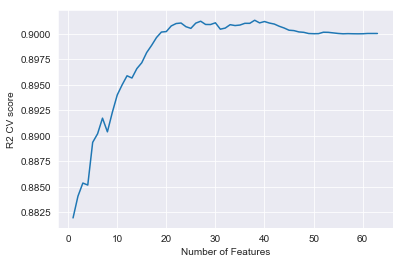

In [40]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()

In [41]:
to_include = X_train_scaled.columns[rfecv.get_support()]

In [42]:
RFE_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[to_include])).fit()

RFE_predictions = RFE_OLS.predict(add_constant(X_test_scaled[to_include]))
RFE_train_r2 = RFE_OLS.rsquared

RFE_test_r2 = r2_score(y_test_scaled, RFE_predictions)

RFE Train R-Squared: 0.91
RFE Test R-Squared: 0.84


Check for Homoscedasticity Assumption


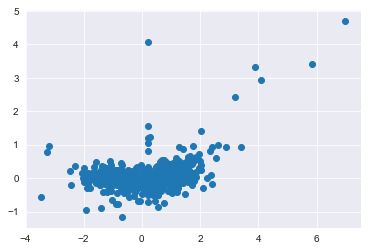

Check for Residuals Normality


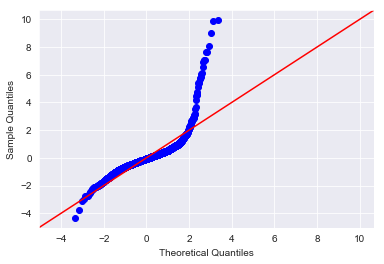

In [43]:
RFE_errors = y_test_scaled - RFE_predictions

print ('RFE Train R-Squared:', round(RFE_train_r2, 2))
print ('RFE Test R-Squared:', round(RFE_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test_scaled, y = RFE_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(RFE_OLS.resid, dist=stats.norm, line='45', fit=True)

In [44]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'n_features'] = len(RFE_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'AIC'] = RFE_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'R2_test'] = RFE_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', '>0.05_pvalues'] = sum(RFE_OLS.pvalues > 0.05)

In [45]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,0.817139,1607.02,6,1
2,Filter,0.767399,2261.76,20,2
3,Wrappper - RFE,0.839864,1085.07,39,14
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [46]:
stepwise_columns = stepwise_selection(X_train_scaled, y_train_scaled, threshold_in = 0.01, verbose=True)

Add  Premature_age-adjusted_mortality with p-value 0.0
Add  Driving_alone_to_work          with p-value 2.96713e-41
Add  %_not_proficient_in_English    with p-value 2.65547e-15
Add  Air_pollution_-_particulate_matter with p-value 1.23279e-15
Add  Percentage_of_households_with_overcrowding with p-value 6.15231e-13
Add  Limited_access_to_healthy_foods with p-value 1.45747e-07
Add  Child_mortality                with p-value 2.4234e-07
Add  Income_inequality              with p-value 9.12374e-08
Add  Median_household_income        with p-value 5.17706e-05
Add  %_Rural                        with p-value 3.38401e-06
Add  Children_in_poverty            with p-value 0.00057853
Add  Long_commute_-_driving_alone   with p-value 0.000666349
Add  Primary_care_physicians        with p-value 0.000122952
Add  Other_primary_care_providers   with p-value 0.00234869
Add  Injury_deaths                  with p-value 0.00437423


In [47]:
stepwise_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[stepwise_columns])).fit()

stepwise_predictions = stepwise_OLS.predict(add_constant(X_test_scaled[stepwise_columns]))
stepwise_train_r2 = stepwise_OLS.rsquared

stepwise_test_r2 = r2_score(y_test_scaled, stepwise_predictions)

In [48]:
stepwise_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1421.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:19   Log-Likelihood:                -617.48
No. Observations:                2356   AIC:                             1267.
Df Residuals:                    2340   BIC:                             1359.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       1.082e-15      0.007   1.66e-13      1.000      -0.013       0.013
Premature_age-adjusted_mortality              -0.8673      0.013    -66.022      0.000      -0.893      -0.842
Driving_alone_to_work                         -0.0723      0.008     -8.666      0.000      -0.089      -0.056
%_not_proficient_in_English                    0.0776      0.008      9.313      0.000       0.061       0.094
Air_pollution_-_particulate_matter            -0.0502      0.008     -5.907      0.000      -0.067      -0.034
Percentage_of_households_with_overcrowding    -0.0693      0.009     -7.829      0.000      -0.087      -0.052
Limited_access_to_healthy_foods                0.0386      0.008      5.110      0.000       0.024       0.053
Child_mortality                               -0.0400      0.008     -5.077      0.000      -0.056      -0.025
Income_inequality                              0.0448      0.008      5.416      0.000       0.029       0.061
Median_household_income                        0.1042      0.013      7.755      0.000       0.078       0.131
%_Rural                                        0.0461      0.009      4.988      0.000       0.028       0.064
Children_in_poverty                            0.0565      0.014      4.008      0.000       0.029       0.084
Long_commute_-_driving_alone                  -0.0307      0.008     -3.694      0.000      -0.047      -0.014
Primary_care_physicians                       -0.0386      0.009     -4.440      0.000      -0.056      -0.022
Other_primary_care_providers                   0.0249      0.008      3.219      0.001       0.010       0.040
Injury_deaths                                 -0.0274      0.010     -2.853      0.004      -0.046      -0.009
==============================================================================
Omnibus:                     1933.147   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83590.238
Skew:                           3.570   Prob(JB):                         0.00
Kurtosis:                      31.294   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Basic Train R-Squared: 0.9
Basic Test R-Squared: 0.84


Check for Homoscedasticity Assumption


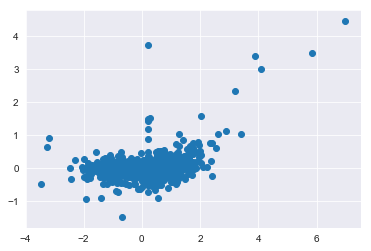

Check for Residuals Normality


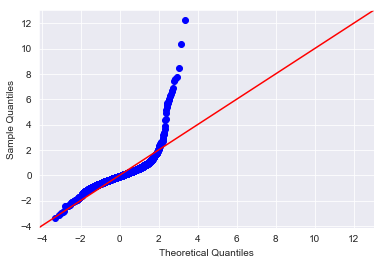

In [49]:
stepwise_errors = y_test_scaled - stepwise_predictions

print ('Basic Train R-Squared:', round(stepwise_train_r2, 2))
print ('Basic Test R-Squared:', round(stepwise_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test_scaled, y = stepwise_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(stepwise_OLS.resid, dist=stats.norm, line='45', fit=True)

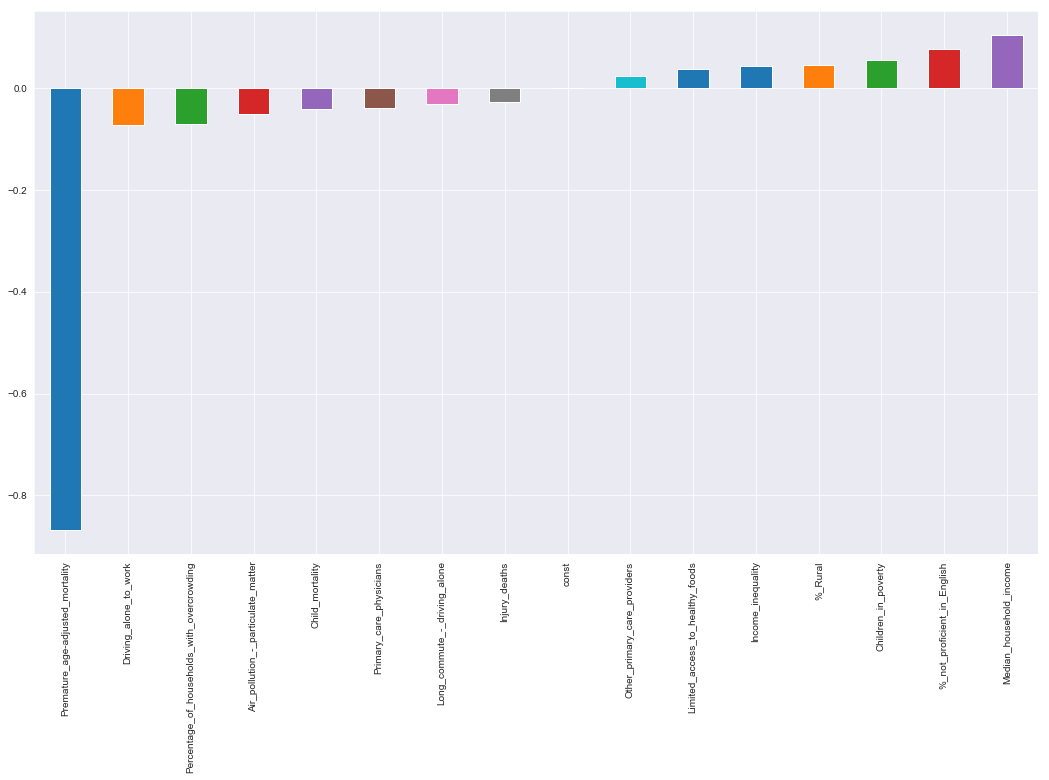

In [50]:
stepwise_OLS.params.sort_values().plot(kind = 'bar', figsize = (18,10))
plt.show()

In [51]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'n_features'] = len(stepwise_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'AIC'] = stepwise_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'R2_test'] = stepwise_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', '>0.05_pvalues'] = sum(stepwise_OLS.pvalues > 0.05)

In [52]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,0.817139,1607.02,6,1
2,Filter,0.767399,2261.76,20,2
3,Wrappper - RFE,0.839864,1085.07,39,14
4,Wrappper - Stepwise,0.84006,1266.96,16,1
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 6. Embedded - Lasso L2 Regression

First we set the all the hyperparameters we are interested in tuning, primarily the 'penalizing' parameters (alpha). The GridSearch function will be able to obtain the best parameters for us by evaluating them using R2 score.

In [53]:
model = Lasso()
lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
                'fit_intercept': [True, False],
                'normalize' : [True, False]}

grid_obj = GridSearchCV(estimator = model, 
                        param_grid = lasso_params, 
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train_scaled, y_train_scaled)
grid_obj.best_params_

{'alpha': 0.05, 'fit_intercept': False, 'normalize': True}

Looks like the best alpha level is 0.05. Let's use the above best selected parameters and train it on our subset of X_train data and subsequently test them on the validation dataset.

In [54]:
final_lasso = grid_obj.best_estimator_.fit(X_train_scaled, y_train_scaled)

train_predictions = final_lasso.predict(X_train_scaled)
test_predictions = final_lasso.predict(X_test_scaled)

print ('Train R2 score of:', round(r2_score(y_train_scaled, train_predictions),2))
print ('Test R2 score of:', round(r2_score(y_test_scaled, test_predictions),2))

Train R2 score of: 0.89
Test R2 score of: 0.82


Not bad at all. Now let's explore the coefficients that the Lasso model chose and plot them.

Lasso picked 8 variables and eliminated the other 55 variables


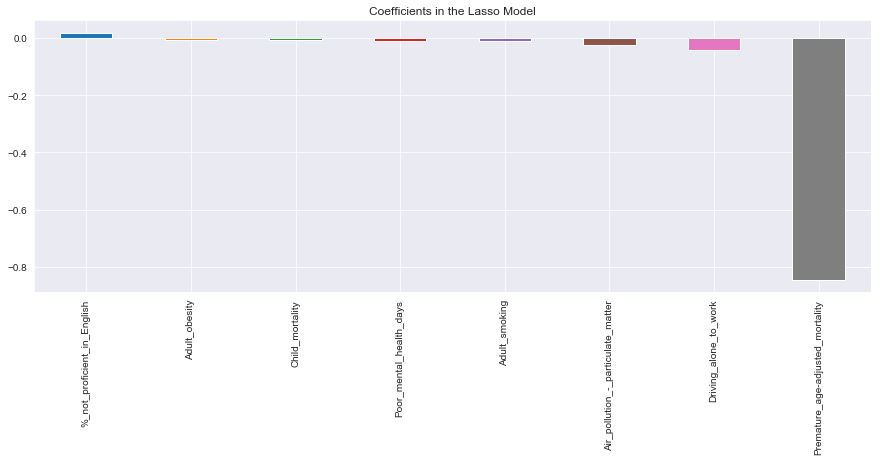

In [55]:
coef = pd.Series(final_lasso.coef_, index = X_train_subset.columns)
final_coef = coef[coef != 0]
final_coef.sort_values(ascending = False, inplace=True)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

final_coef.plot(kind = "bar", figsize=(15,5))
plt.title("Coefficients in the Lasso Model")
plt.show()

How about the residuals?

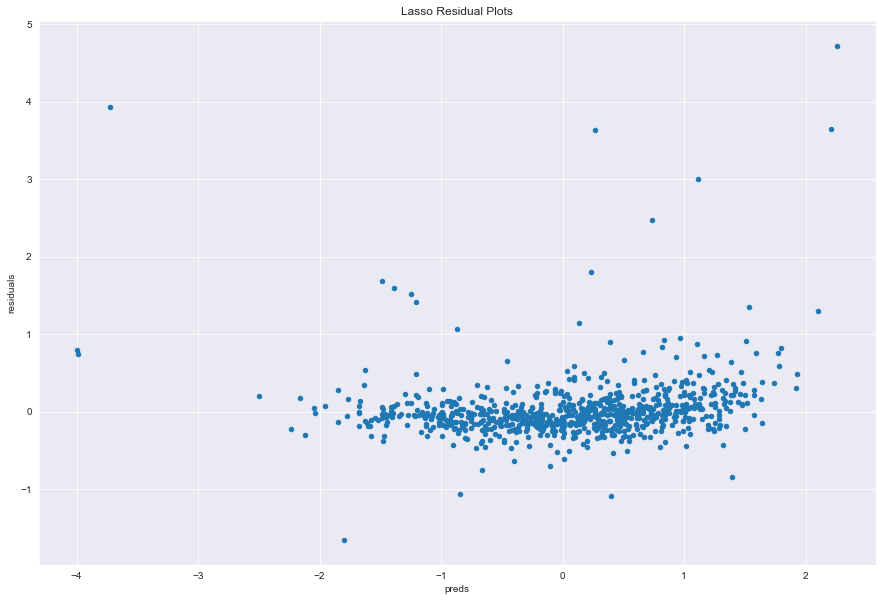

In [56]:
preds = pd.DataFrame({"preds":final_lasso.predict(X_test_scaled), "true":y_test_scaled})
preds["residuals"] = preds["true"] - preds["preds"]

preds.plot(x = "preds", y = "residuals", kind = "scatter", figsize=(15,10))
plt.title('Lasso Residual Plots')
plt.show()

In [57]:
Lasso_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[final_coef.index])).fit()

Lasso_predictions = Lasso_OLS.predict(add_constant(X_test_scaled[final_coef.index]))
Lasso_train_r2 = Lasso_OLS.rsquared

Lasso_test_r2 = r2_score(y_test_scaled, Lasso_predictions)

In [58]:
Lasso_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2463.
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:49:23   Log-Likelihood:                -703.99
No. Observations:                2356   AIC:                             1426.
Df Residuals:                    2347   BIC:                             1478.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               1.082e-15      0.007   1.61e-13      1.000      -0.013       0.013
%_not_proficient_in_English            0.0545      0.007      7.713      0.000       0.041       0.068
Adult_obesity                         -0.0136      0.009     -1.529      0.126      -0.031       0.004
Child_mortality                       -0.0466      0.008     -5.806      0.000      -0.062      -0.031
Poor_mental_health_days               -0.0271      0.011     -2.516      0.012      -0.048      -0.006
Adult_smoking                         -0.0084      0.012     -0.678      0.498      -0.033       0.016
Air_pollution_-_particulate_matter    -0.0520      0.008     -6.544      0.000      -0.068      -0.036
Driving_alone_to_work                 -0.0690      0.008     -8.771      0.000      -0.084      -0.054
Premature_age-adjusted_mortality      -0.8478      0.011    -79.566      0.000      -0.869      -0.827
==============================================================================
Omnibus:                     2075.227   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114549.911
Skew:                           3.907   Prob(JB):                         0.00
Kurtosis:                      36.254   Cond. No.                         4.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'n_features'] = len(Lasso_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'AIC'] = Lasso_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'R2_test'] = Lasso_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', '>0.05_pvalues'] = sum(Lasso_OLS.pvalues > 0.05)

In [60]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.839762,1118.37,64,41
1,Basic - Top Correlation,0.817139,1607.02,6,1
2,Filter,0.767399,2261.76,20,2
3,Wrappper - RFE,0.839864,1085.07,39,14
4,Wrappper - Stepwise,0.84006,1266.96,16,1
5,Embedded - Lasso,0.833313,1425.97,9,3


### Model Chosen - Stepwise Selection

Okay, looking purely by R2 scores, model complexity and optimum number of features, we have decided to go for the Stepwise model. However we will still need to check if the model fits the regression assumptions. First let check for multicollinearity using the VIF metric. 

In [75]:
stepwise_baseline = X_train_scaled[stepwise_columns]
stepwise_baseline['Intercept'] = 1

stepwise_VIF = pd.DataFrame()
stepwise_VIF["variables"] = stepwise_baseline.columns
stepwise_VIF["VIF"] = [variance_inflation_factor(stepwise_baseline.values, i) for i in range(stepwise_baseline.shape[1])]

stepwise_VIF

,variables,VIF
0,Premature_age-adjusted_mortality,4.082920
1,Driving_alone_to_work,1.645818
2,%_not_proficient_in_English,1.644776
3,Air_pollution_-_particulate_matter,1.709083
4,Percentage_of_households_with_overcrowding,1.856551
5,Limited_access_to_healthy_foods,1.351198
6,Child_mortality,1.472275
7,Income_inequality,1.616643
8,Median_household_income,4.272689
9,%_Rural,2.019534


Cool, since no features are more than 5, multicollinearity is not a big concern here. Next we check for homoscedasticity by plotting the residuals.

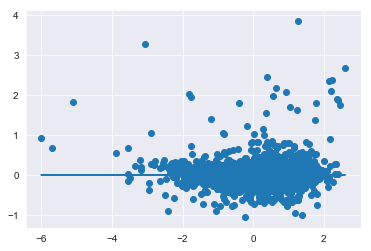

In [79]:
stepwise_updated = X_train_scaled[stepwise_columns]
stepwise_updated.insert(0, 'const', 1)

stepwise_OLS.predict(stepwise_updated)
len(stepwise_OLS.resid)

plt.scatter(stepwise_OLS.predict(stepwise_updated), stepwise_OLS.resid)
plt.plot(stepwise_OLS.predict(stepwise_updated), [0 for i in range(len(X_train_scaled))])
plt.show()

This looks fine with no concerning trends. No we look at the normality of the errors using the QQ plot.

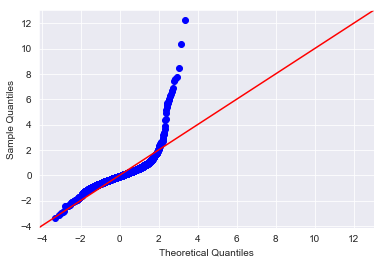

In [80]:
fig = sm.graphics.qqplot(stepwise_OLS.resid, dist=stats.norm, line='45', fit=True)

This looks pretty bad. 

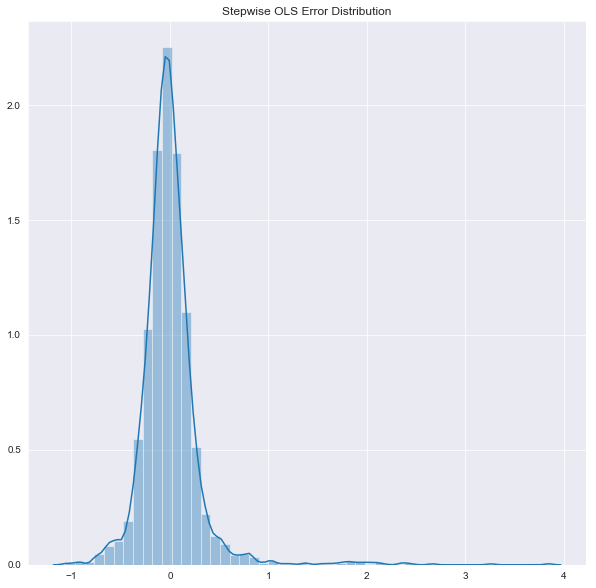

In [63]:
plt.figure(figsize = (10, 10))
sns.distplot(stepwise_OLS.resid)
plt.title('Stepwise OLS Error Distribution')
plt.show()

In [64]:
updated = X_train_scaled
updated['Life_expectancy'] = y_train_scaled

In [65]:
list_range = np.linspace(0.8,1, 21)
for i in list_range:
    print (i, updated.Life_expectancy.quantile(i))

0.8 0.7544443672559659
0.81 0.79020718179865
0.8200000000000001 0.8280594559289071
0.8300000000000001 0.8720888186230491
0.8400000000000001 0.9001106114898716
0.8500000000000001 0.9265005010518657
0.86 0.9812511035459645
0.87 1.0153140464739971
0.88 1.05448519655749
0.89 1.1251568026252534
0.9 1.1784074967155682
0.91 1.2444326410829636
0.92 1.3098006396564634
0.93 1.3906435818807443
0.9400000000000001 1.4406065969401043
0.95 1.531212184623704
0.96 1.5938992148663078
0.97 1.7856987607744879
0.98 1.9298588496494689
0.99 2.33111213905232
1.0 5.264798677237748


In [72]:
to_use = updated[updated.Life_expectancy < 2]
to_use_x_train_scaled = to_use.drop(['Life_expectancy'], axis = 1)
to_use_y_train_scaled = to_use.Life_expectancy

In [73]:
stepwise_OLS_updated = OLS(to_use_y_train_scaled, to_use_x_train_scaled[stepwise_columns]).fit()

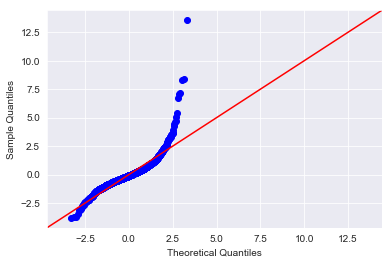

In [74]:
fig = sm.graphics.qqplot(stepwise_OLS_updated.resid, dist=stats.norm, line='45', fit=True)